### Import related API

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential, layers, backend
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, LeakyReLU, GRU, BatchNormalization
from keras.layers.core import RepeatVector
from keras.callbacks import EarlyStopping

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from itertools import product
from tensorflow.python.ops import math_ops
from tensorflow.keras.metrics import Metric
%matplotlib inline

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Control the upper limit of GPU memory

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.keras.backend.set_session(sess)

### Read the data

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

def read(path):
    return pd.read_csv(path)

In [4]:
path = "WeeklyFinalData.csv"
finalData = read(path)

In [5]:
train = finalData

In [6]:
date = train["Date"]
train.drop("Date",axis=1,inplace=True)

## Data preprocessing

### Add lag time as a predicted factor 
1. Add lag time from 1 to 4 for CCSP (Yangtze River nonferrous metals, China)
2. Split the data to Training set & Test set

In [7]:
def buildTrain(train, pastWeek=1, futureWeek=4, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
        X = np.array(train.iloc[i:i+defaultWeek])
        X = np.append(X,train["CCSP"].iloc[i+defaultWeek:i+pastWeek])
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    return np.array(X_train), np.array(Y_train)

### Min-max scaling 
The data is scaled to a fixed range [0,1]

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

### Setting the format of the learning graph

In [9]:
def show_raw_visualization(data):

    fig, axes = plt.subplots(
        nrows=int(round(data.shape[1]/2,0)), ncols=2, figsize=(15, 5), dpi=80, facecolor="w", edgecolor="k"
    )

    for i in range(data.shape[1]):
        t_data = data.iloc[:,i]
        ax = t_data.plot(
            ax=axes[i % 2],
            color="black",
            # title="Lag:{0}, {1} curve".format(lag_time+1, data.columns[i])
        )
    
#     fig.set_size_inches(10,15)
        
    plt.tight_layout()

### Add data to the specified time lag and normalize

In [10]:
def dataTimeLag(time_lag):

    print("Lag time = {}".format(time_lag))
    ## Time lag
    X1_train, Y1_train= buildTrain(train, pastWeek=time_lag, futureWeek=1)

    ## Split date to training & test data
    X1_training = pd.DataFrame(X1_train[0:int(X1_train.shape[0]*0.8)])
    X1_test = pd.DataFrame(X1_train[int(X1_train.shape[0]*0.8):])

    Y1_training = pd.DataFrame(Y1_train[0:int(Y1_train.shape[0]*0.8)])
    Y1_test = pd.DataFrame(Y1_train[int(Y1_train.shape[0]*0.8):])

    # Normalize
#     print("---Normalize---")
#     X1_training_scaled = sc.fit_transform(X1_training)
#     X1_test_scaled = sc.transform(X1_test)

#     Y1_training_scaled = sc.fit_transform(Y1_training)
#     Y1_test_scaled = sc.transform(Y1_test)
    
    ##Test
#     Y1_test_scaled = Y1_test.values

    # Check the data dimension
#     print("---Check the data dimension---")
#     print("X1_training_scaled:{0}".format(X1_training_scaled.shape))
#     print("Y1_training_scaled:{0}".format(Y1_training_scaled.shape))
#     print("X1_test_scaled:{0}".format(X1_test_scaled.shape))
#     print("Y1_test_scaled:{0}".format(Y1_test_scaled.shape))

#     return [X1_training, Y1_training, X1_test, Y1_test]
    return [X1_training, Y1_training, X1_test, Y1_test]

In [11]:
data = dataTimeLag(4)
statistical_data = sc.fit(data[0])


Lag time = 4


## Building Model

In [12]:
class DINKLE_Accuracy(Metric):

    def __init__(self, name="DINKLE_Accuracy", **kwargs):
        super(Metric, self).__init__(name=name, **kwargs)
#         self.total_count = self.add_weight(name = "total_count", initializer=init_ops.zeros_initializer)
#         self.match_count = self.add_weight(name = "match_count", initializer=init_ops.zeros_initializer)
        self.matches_rate = self.add_weight(name = "matches_rate", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        
#         y_true = tf.convert_to_tensor(sc.inverse_transform(y_true))
#         y_pred = tf.convert_to_tensor(sc.inverse_transform(y_pred))
            
        match_count = tf.reduce_sum(tf.cast(tf.less_equal(tf.abs(y_true- y_pred), 0.02), dtype = tf.float32))
        total_count = y_true.shape[0]
        self.matches_rate = math_ops.div_no_nan(match_count, total_count)
#         self.matches_rate = accuracy_eva(y_true, y_pred)
         
    def result(self):
        return  self.matches_rate
    
    def reset_state(self):
        self.matches_rate = tf.zeros(shape=(1, 1))

In [13]:
def buildTwoLayerNN(training_data_shape, setting, accuracy):

    keras.backend.clear_session()
    regressor = Sequential()
    L2 = tf.keras.regularizers.L2(setting[4])
    regressor.add(Dense(units=setting[1], activation =setting[0], batch_input_shape=(None,training_data_shape), kernel_initializer = setting[2], kernel_regularizer= L2))
    regressor.add(Dense(units=1)) 

    # adam = optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999, decay=1e-6)

    regressor.compile(optimizer=setting[3], loss="mean_squared_error", metrics=[accuracy])
    # regressor.summary()

    return regressor

### Performance evaluation

In [14]:
def accuracy_eva(y_true, y_pred):
    
    
    total_times = y_true.shape[0]
    
#     raw_data=raw_data.values
    
  ##Test
#     print(type(raw_data))
#     print(type(predict_data))

    performance = []
    
    for threshold in range(1000,3001,1000):
#         correct_times = 0
        
#         for i in range(y_true.shape[0]): 

        correct_times = tf.reduce_sum(tf.cast(tf.less_equal(tf.abs(y_true- y_pred), threshold), dtype = tf.float32))

        performance.append(correct_times/total_times)

    return performance

### Training the model

In [22]:
def show_raw_visualization(data):

    fig, axes = plt.subplots(
        nrows=int(round(data.shape[1]/2,0)), ncols=2, figsize=(15, 5), dpi=80, facecolor="w", edgecolor="k"
    )

    for i in range(data.shape[1]):
        t_data = data.iloc[:,i]
        t_data.plot(
            ax=axes[i % 2],
            color="black",
            title="{0} curve".format(data.columns[i])
        )
        
    
#     fig.set_size_inches(10,15)
        
    plt.tight_layout()

In [23]:
early_stopper = EarlyStopping(patience=5)

In [24]:
def training_model(data, setting, setting_name, epoch, patience, batch_size):

    ## data
    ### [X1_training_scaled, Y1_training_scaled, X1_test_scaled, Y1_test_scaled]

    ## Training model
    statistics = sc.fit(data[0])
    X1_training = sc.transform(data[0])
    X1_test = sc.transform(data[2])

    Y1_training = sc.fit_transform(data[1])
    
    #training_data_shape, activation_function, hidden_node, initializer, optimizer
    input_sahpe = X1_training.shape[1]
    
    accuracy = DINKLE_Accuracy()
    
    regressor = buildTwoLayerNN(input_sahpe, setting[1:], accuracy)
    
    MSE_list = []
    accuracy_list = []

    for _ in range(epoch):
        
        minimum_loss = 100
        current_times = 0
        
        
        if (current_times >= patience):
            regressor.load_weights("model_weight.h5")
            break
            
            
        else:
            
            for i in range(0, X1_training.shape[0], batch_size):

                end = i + batch_size

                if end <= X1_training.shape[0]:
        #             x = data[0][i:end].reshape(16,1,-1)
                    x = X1_training[i:end]
                    y = Y1_training[i:end]
                    regressor.train_on_batch(x, y)

                else:
        #             x = data[0][i:data[0].shape[0]-1].reshape(16-(end-(data[0].shape[0]-1)),1,-1)
                    x = X1_training[i:X1_training.shape[0]-1]
                    y = Y1_training[i:X1_training.shape[0]-1]
                    regressor.train_on_batch(x, y)
            
            
#             y_pred = regressor.predict(X1_training)
            y_pred = sc.inverse_transform(regressor.predict(X1_training))
            y_true = data[1]
            loss = tf.reduce_mean(tf.square(y_true - y_pred)).numpy()
            accuracy = tf.reduce_sum(tf.cast(tf.less_equal(tf.abs(y_true- y_pred), 2000), dtype = tf.float32)).numpy()/y_true.shape[0]
            
            MSE_list.append(loss)
            accuracy_list.append(accuracy)
            
            if(loss < minimum_loss):
                minimum_loss = loss
                current_times=0
                regressor.save_weights("model_weight.h5")
            
            else:
                current_times += 1
    
#     print(MSE_list)
    show_raw_visualization(pd.DataFrame({"Loss":MSE_list, "Accuracy":accuracy_list}))
    ## Draw the learning graph
    
#     RMSE = [i for i in history.history["root_mean_squared_error"]]
#     score_data = pd.DataFrame({"Loss":history.history["loss"], "Accuracy":history.history["DINKLE_Accuracy"]})

    ## Evaluate the model using testing data
    # scores = regressor.evaluate(data[2], data[3])  

    ##Train
    train_predict = regressor.predict(X1_training)
    train_predict = sc.inverse_transform(train_predict)
    train_performance = accuracy_eva(data[1], train_predict)
    
    test_predict = regressor.predict(X1_test)
    test_predict = sc.inverse_transform(test_predict)
    test_performance = accuracy_eva(data[3], test_predict)
    ##Test
    
#     if (np.isnan(predict).sum()>0):
#         print(setting_name)
#         score = float("inf")
#         accuracy = 0
    
#     else:

#     Y_testing_data = data[3]
#     predict = sc.inverse_transform(predict)
    
#     score = np.sqrt(mean_squared_error(predict, Y_testing_data))
#     accuracy = accuracy_eva(Y_testing_data, predict, 2000)
    
#     performance = {
#         "Epochs":setting_name[0],
#         "Activation function":setting_name[1],
#         "Hidden nodes":setting_name[2],
#         "Initializer":setting_name[3],
#         "Optimizer":setting_name[4],
#         "Regularizer":setting_name[5],
#         "Train_Accuracy(1000)":train_performance[0].numpy(),
#         "Train_Accuracy(2000)":train_performance[1].numpy(),
#         "Train_Accuracy(3000)":train_performance[2].numpy(),
#         "Test_Accuracy(1000)":test_performance[0].numpy(),
#         "Test_Accuracy(2000)":test_performance[1].numpy(),
#         "Test_Accuracy(3000)":test_performance[2].numpy()
# #         "Out-of-sample RMSE": score,
# #         "Out-of-sample Accuracy": accuracy
#       # "RMSE":scores[1]
#     }
    # print("[Out-of-sample performance] \nEpochs: %d\nActivation function: %s\nHidden nodes: %d\nOptimizer: %s\nRMSE: %.3f" %(setting[0], setting[1], setting[2], setting[4], scores[1]))
    # show_raw_visualization(score_data)
    # print()

    ##Test
#     predicts = pd.DataFrame(predict)
    return regressor

### Control model Hyperparameter
such as:
* input factor dimension
* epoch
* activation_function
* hidden_node
* initializer
* optimizer

In [25]:
def main(input_data):

    ## data, epoch, activation_function, hidden_node, initializer, optimizer
    ## epoches, activation_functions, hidden_nodes選項
#     epoches = [100, 200, 300]
#     activation_functions = ["sigmoid", "tanh", "relu"]
#     hidden_nodes = [5, 8, 11]

    #Test
    epoches = [100]
    activation_functions = ["sigmoid"]
    hidden_nodes = [5]


    ## initializer 選項
    small_random = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    Xavier = tf.keras.initializers.GlorotNormal()
    initializers = [small_random, Xavier]
    initializers_name = ["small_random", "Xavier"]

    # optimizer & learning rate decay
#     learning_rate_fn = tf.keras.optimizers.schedules.CosineDecay(
#       initial_learning_rate = 0.01, 
#       decay_steps = 10
#     )

#     learning_rate_fn = tf.keras.optimizers.schedules.ExponentialDecay(
#       initial_learning_rate = 0.01, 
#       decay_steps = 100, 
#       decay_rate = 0.05,
#     )

#     SGD_cosine = tf.keras.optimizers.SGD(
#       learning_rate=learning_rate_fn,
#       name = "SGD_with_cosine"
#     )

#     Adam_cosine = tf.keras.optimizers.Adam(
#       learning_rate=learning_rate_fn,
#       name = "Adam_with_cosine"
#     )

#     Momentum = tf.keras.optimizers.SGD(
#       learning_rate=0.01,
#       momentum=0.9,
#       name = "Momentum"
#     )

#     Mom_cosine = tf.keras.optimizers.SGD(
#       learning_rate=learning_rate_fn,
#       momentum=0.9,
#       name = "Momentum_with_cosine"
#     )

    regularizer= [0, 0.001, 0.0001]
    
    ## optimizers 選項
#     optimizers = ["SGD", SGD_cosine, "Adam", Adam_cosine, Momentum, Mom_cosine]
#     optimizers_name = ["SGD", "SGD_with_cosine", "Adam", "Adam_with_cosine", "Momentum", "Momentum_with_cosine"]

    ##Test
    optimizers = ["SGD","Adam"]
    optimizers_name = ["SGD","Adam"]

    ##所有hyperparameter的組合
    sets = list(product(epoches, activation_functions, hidden_nodes, initializers, optimizers, regularizer))
    sets_name = list(product(epoches, activation_functions, hidden_nodes, initializers_name, optimizers_name, regularizer))

    data = input_data
    RMSE_scores = pd.DataFrame(columns = ["Epochs", "Activation function", "Hidden nodes", "Optimizer", "Initializer","Regularizer","Train_Accuracy(1000)","Train_Accuracy(2000)","Train_Accuracy(3000)","Test_Accuracy(1000)","Test_Accuracy(2000)","Test_Accuracy(3000)"])
    predicts = pd.DataFrame(columns = list(range(94)))
    
    for i in range(len(sets)):
        
#         performance = training_model(data, sets[i], sets_name[i], 100, 5, 16)
        
#         RMSE_scores = RMSE_scores.append(performance, ignore_index=True)
#         predicts = predicts.append(predict, ignore_index=True)

        regressor = training_model(data, sets[i], sets_name[i], 100, 5, 16)
    
    return regressor

Lag time = 4


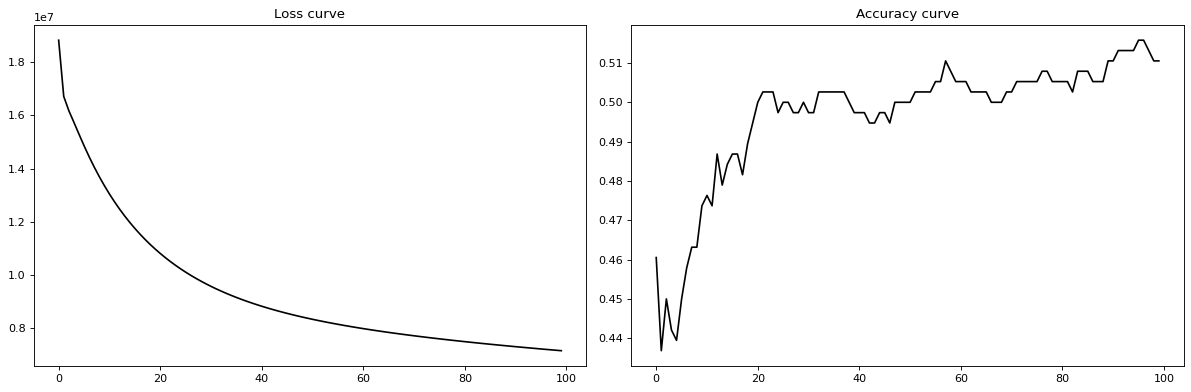

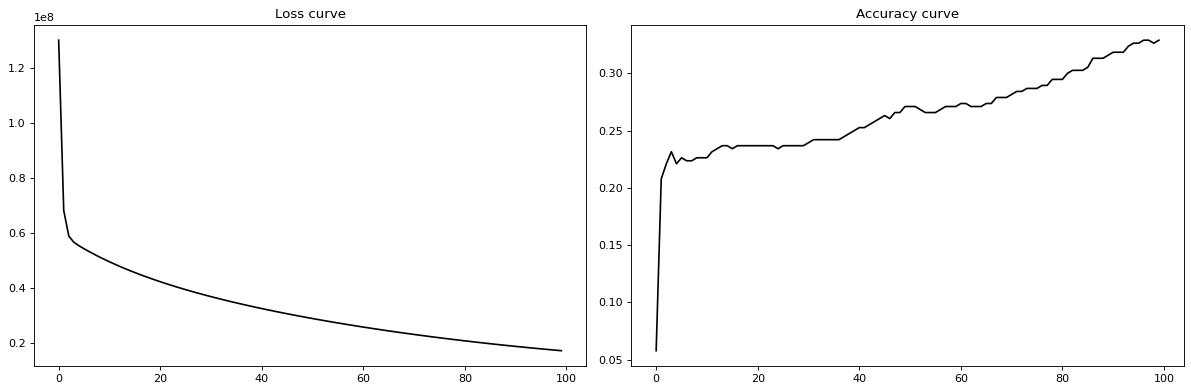

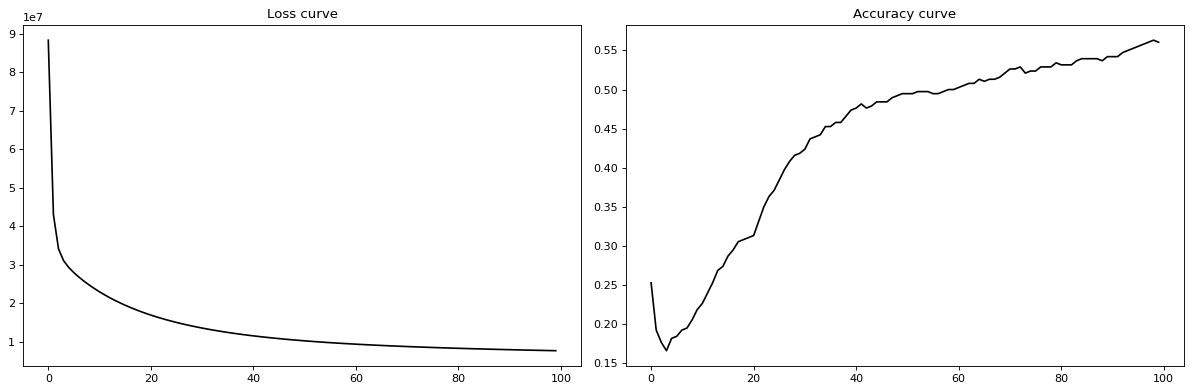

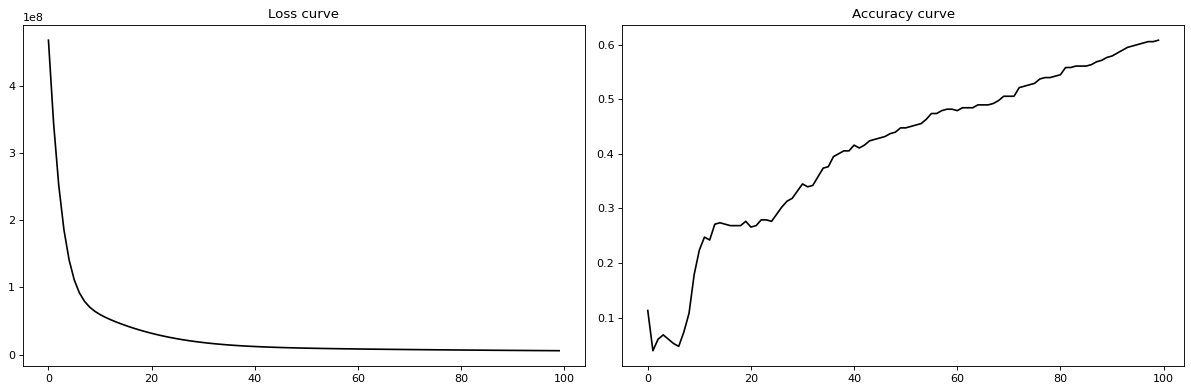

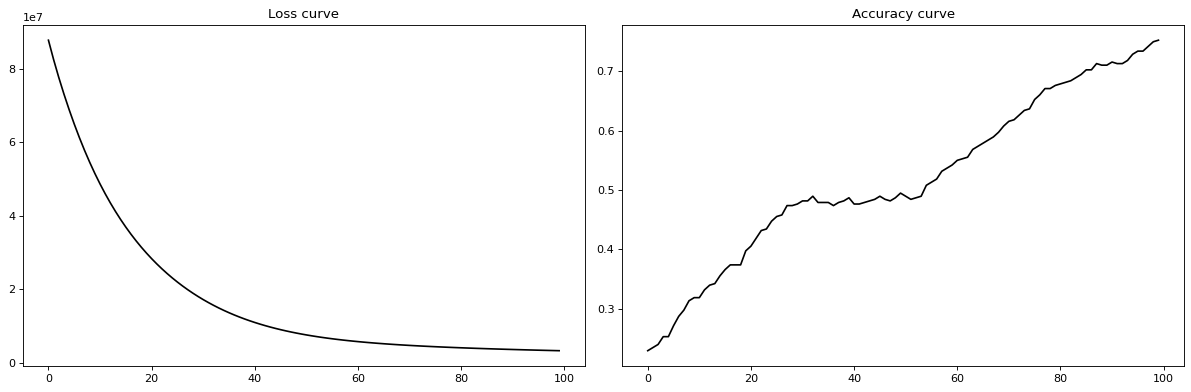

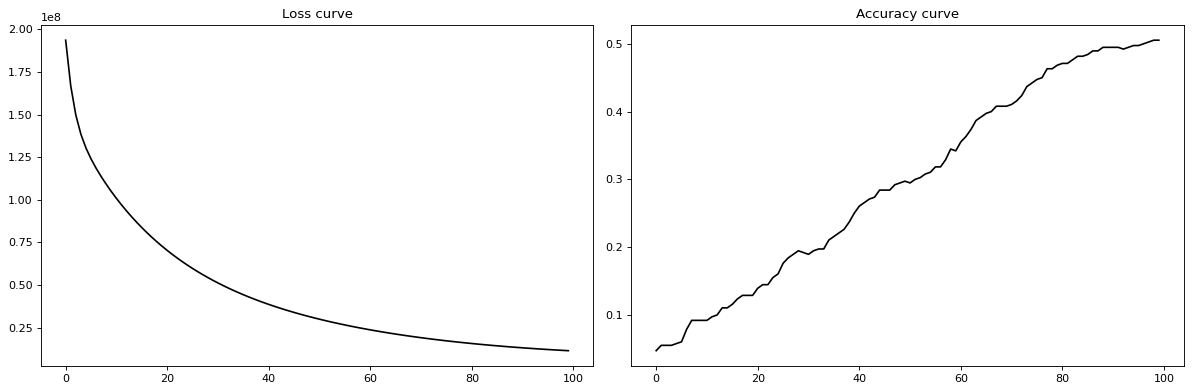

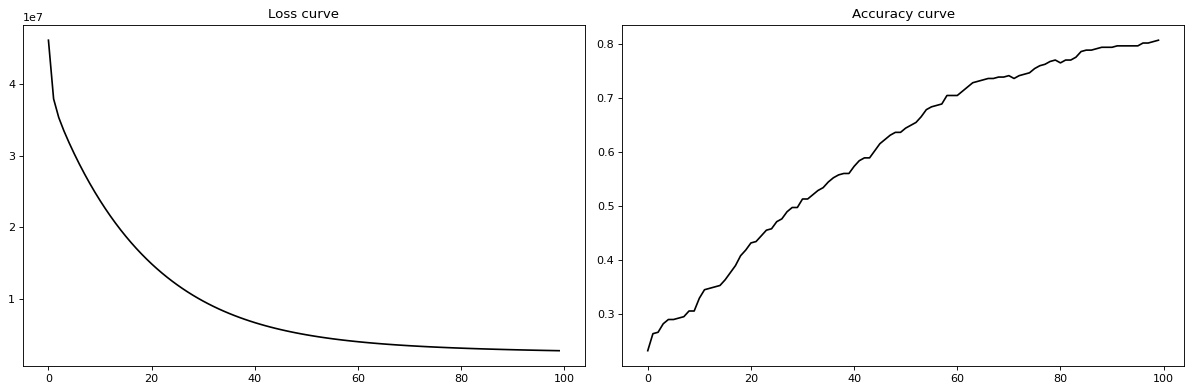

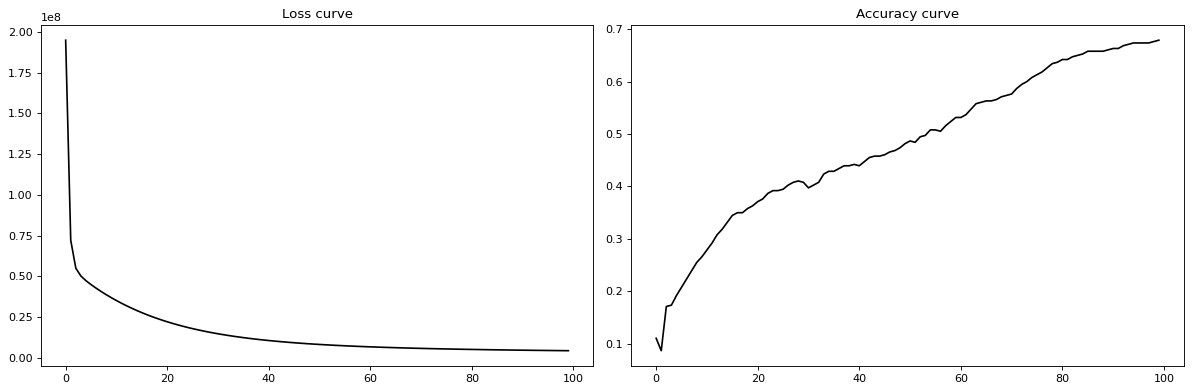

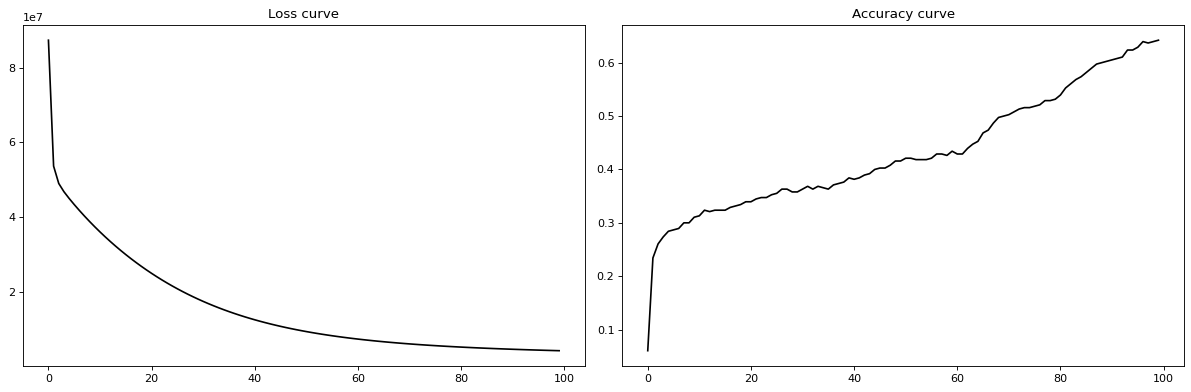

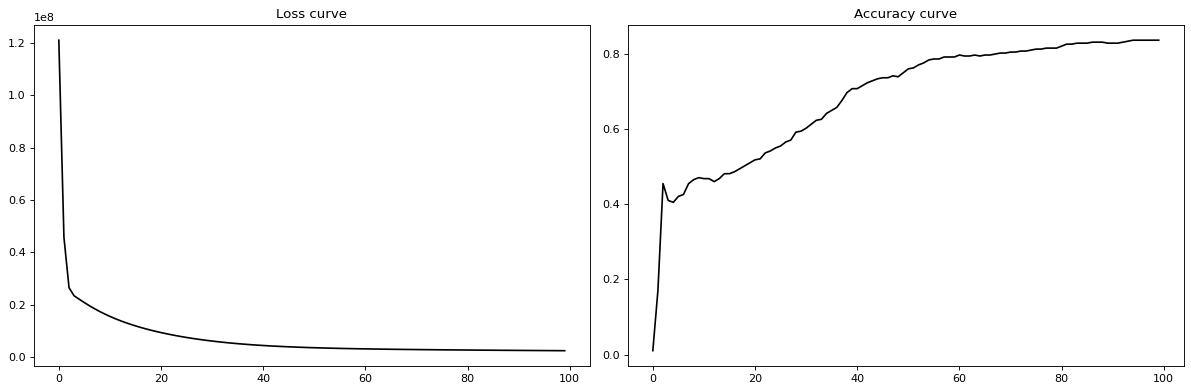

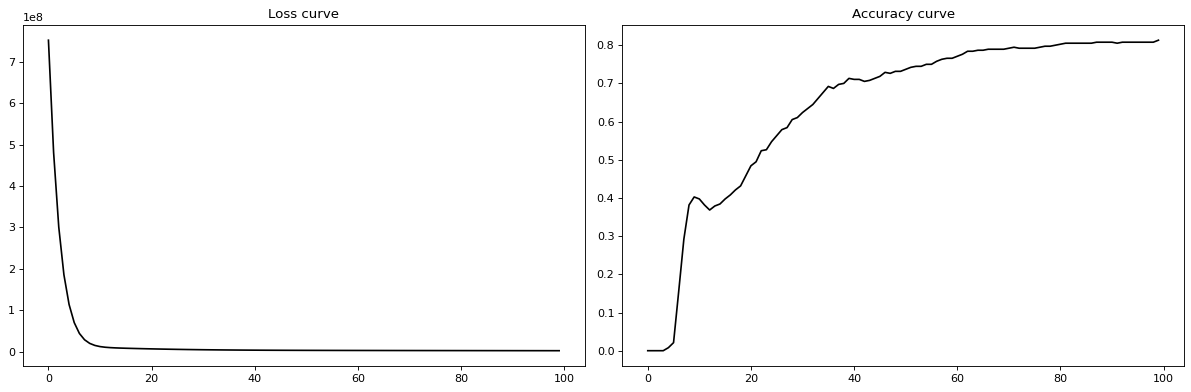

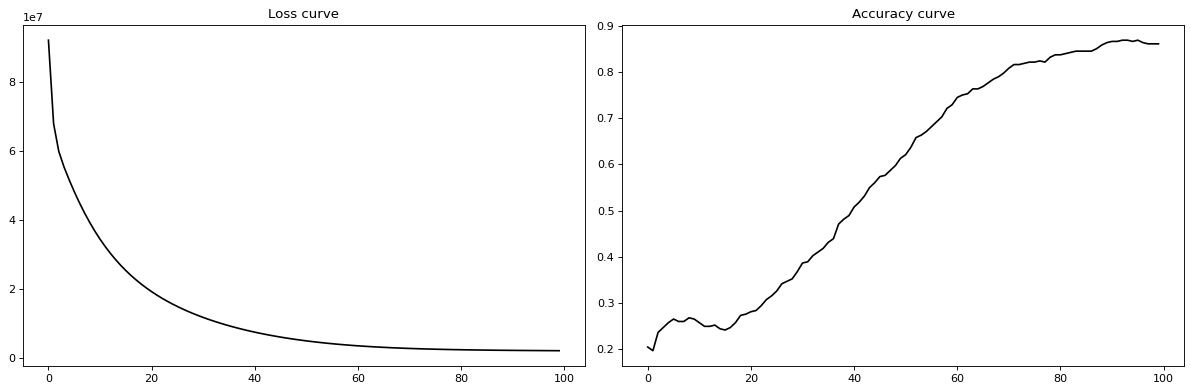

In [26]:
if __name__ == "__main__":
    data = dataTimeLag(4)
    regressor= main(data)

In [20]:
regressor.get_weights()

[array([[ 0.66981816, -0.00185583, -0.43123117, -0.23714457, -0.3022872 ],
        [ 0.3859317 , -0.66388863, -0.12450728,  0.24026656,  0.12856051],
        [-0.21113771, -0.59672266,  0.1578319 ,  0.10017514, -0.16279872],
        [ 0.11209968, -0.09786788, -0.14133607, -0.09852706, -0.48142993],
        [ 0.45367023, -0.67097205,  0.1662183 , -0.53290474,  0.03831604],
        [ 0.0689048 ,  0.21840939, -0.01118462,  0.10771193,  0.00849524],
        [ 0.10023853, -0.07345399,  0.04496853, -0.03738929, -0.6364667 ],
        [ 0.0225752 , -0.43389833, -0.38953477, -0.36862916, -0.42242354],
        [ 0.23333198, -0.42826366, -0.4155068 , -0.64356375, -0.15603791],
        [ 0.03230276,  0.19338124, -0.14047655,  0.09628647,  0.01243672],
        [ 0.00860401,  0.15226258,  0.12947576,  0.51546574,  0.4402463 ],
        [ 0.39942342,  0.55632216, -0.44653222, -0.07912989,  0.1159208 ],
        [ 0.5866733 ,  0.4791152 ,  0.28848127,  0.17031142, -0.3601826 ],
        [-0.3670198 , -0.

In [21]:
RMSE_scores.sort_values("Train_Accuracy(2000)", inplace=True, ascending=False)

NameError: name 'RMSE_scores' is not defined

In [ ]:
RMSE_scores

In [ ]:
RMSE_scores.to_csv("Tester.csv")

### The best top five models based on in-sample data

In [ ]:
RMSE_scores.sort_values("In-sample RMSE", inplace=True)
RMSE_scores.head(5)

### Ensemble the top 5 models

In [ ]:
top_five_model = predicts.iloc[list(RMSE_scores.head(5).index),:]
ensemble_predict = top_five_model.apply(lambda x: x.mean())
ensemble_RMSE = np.sqrt(mean_squared_error(ensemble_predict, data[3]))
emsemble_accuracy = accuracy_eva(data[3], ensemble_predict, 3000)
print("RMSE of ensembling the top 5 models: %.5f" %ensemble_RMSE)
print("Accuracy of ensembling the top 5 models: %.5f" %emsemble_accuracy)

plt.figure(figsize=(10,4))
plt.scatter(range(data[3].shape[0]), data[3], color='black', label = 'Raw data')
plt.plot(ensemble_predict, label = 'Predicted value')
plt.legend()
plt.xlabel("Sample index (weekly)")
plt.ylabel("Cooper price value")
plt.savefig('Result_ensemble_model.png')

### Save all the results of model configuration in in-sample data as Settings_RMSE_scores.csv

In [ ]:
RMSE_scores.reset_index(inplace=True, drop=True)
RMSE_scores.to_csv("Settings_score_DINKLE.csv", index=False)
RMSE_scores

### The best configuration in out-of-sample data

In [ ]:
RMSE_scores.sort_values("Out-of-sample RMSE", inplace=True)
RMSE_scores.reset_index(inplace=True, drop=True)
RMSE_scores[RMSE_scores["Out-of-sample RMSE"]==min(RMSE_scores["Out-of-sample RMSE"])]